## Implementing logistic regression from scratch
The goal of this assignment is to implement your own logistic regression classifier. You will:

Extract features from Amazon product reviews. Convert an SFrame into a NumPy array. Implement the link function for logistic regression. Write a function to compute the derivative of the log likelihood function with respect to a single coefficient. Implement gradient ascent. Given a set of coefficients, predict sentiments. Compute classification accuracy for the logistic regression model.

In [1]:
import pandas as pd
import numpy as np
import string
import json

In [2]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def readjson(path):
    try:
        with open(path,'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        raise FileNotFoundError( "Please check the path and try agaian!!!")

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')

In [4]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Let us quickly explore more of this dataset. The name column indicates the name of the product. Try listing the name of the first 10 products in the dataset.

After that, try counting the number of positive and negative reviews.

In [5]:
products[:10]

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1


In [6]:
products = products[products['rating'] != 3]

In [7]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [8]:
products[:10]

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1


### Apply text cleaning on the review data
In this section, we will perform some simple feature cleaning using data frames. The last assignment used all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). We compiled a list of 193 most frequent words into the JSON file named important_words.json. Load the words into a list important_words.

In [9]:
important_words = readjson('important_words.json')

In [10]:
important_words[:10]

['baby',
 'one',
 'great',
 'love',
 'use',
 'would',
 'like',
 'easy',
 'little',
 'seat']

Let us perform 2 simple data transformations:

Remove punctuation Compute word counts (only for important_words) We start with the first item as follows:

If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the review columns as follows:

In [11]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [12]:
products['review_clean'] = products['review'].apply(remove_punctuation)

Now we proceed with the second item. For each word in important_words, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in important_words which keeps a count of the number of times the respective word occurs in the review text.

Note: There are several ways of doing this. One way is to create an anonymous function that counts the occurrence of a particular word and apply it to every element in the review_clean column. Repeat this step for every word in important_words. Your code should be analogous to the following:

In [13]:
products['review_split'] = products['review_clean'].apply(lambda x: x.split())
for word in important_words:
    products[word] = products['review_split'].apply(lambda s : s.count(word))

After #4 and #5, the data frame products should contain one column for each of the 193 important_words. As an example, the column perfect contains a count of the number of times the word perfect occurs in each of the reviews.

Now, write some code to compute the number of product reviews that contain the word perfect

First create a column called contains_perfect which is set to 1 if the count of the word perfect (stored in column perfect is >= 1. Sum the number of 1s in the column contains_perfect.

In [14]:
products['contains_perfect'] = products['perfect'].apply(lambda pf: 1 if pf >=1 else 0)
sum(products['contains_perfect'] == 1)

2955

### Convert data frame to multi-dimensional array
It is now time to convert our data frame to a multi-dimensional array. Look for a package that provides a highly optimized matrix operations. In the case of Python, NumPy is a good choice.

Write a function that extracts columns from a data frame and converts them into a multi-dimensional array. We plan to use them throughout the course, so make sure to get this function right.

The function should accept three parameters:

dataframe: a data frame to be converted features: a list of string, containing the names of the columns that are used as features. label: a string, containing the name of the single column that is used as class labels. The function should return two values:

one 2D array for features one 1D array for class labels The function should do the following:

Prepend a new column constant to dataframe and fill it with 1's. This column takes account of the intercept term. Make sure that the constant column appears first in the data frame. Prepend a string 'constant' to the list features. Make sure the string 'constant' appears first in the list. Extract columns in dataframe whose names appear in the list features. Convert the extracted columns into a 2D array using a function in the data frame library. If you are using Pandas, you would use as_matrix() function. Extract the single column in dataframe whose name corresponds to the string label. Convert the column into a 1D array. Return the 2D array and the 1D array.

In [15]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array) 

Using the function written in #8, extract two arrays feature_matrix and sentiment. The 2D array feature_matrix would contain the content of the columns given by the list important_words. The 1D array sentiment would contain the content of the column sentiment.

Quiz Question: How many features are there in the feature_matrix?

Quiz Question: Assuming that the intercept is present, how does the number of features in feature_matrix relate to the number of features in the logistic regression model?

In [16]:
feature_matrix, label_array = get_numpy_data(products, important_words, 'sentiment')

In [17]:
feature_matrix.shape

(53072, 194)

Estimating conditional probability with link function

P(yi=+1|xi,w)=1/(1+exp(−wTh(xi)))

where the feature vector h(x_i) represents the word counts of important_words in the review x_i. Write a function named predict_probability that implements the link function.

Take two parameters: feature_matrix and coefficients. First compute the dot product of feature_matrix and coefficients. Then compute the link function P(y = +1 | x,w). Return the predictions given by the link function.

In [18]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = 1/(1+np.exp(-score))
    return predictions

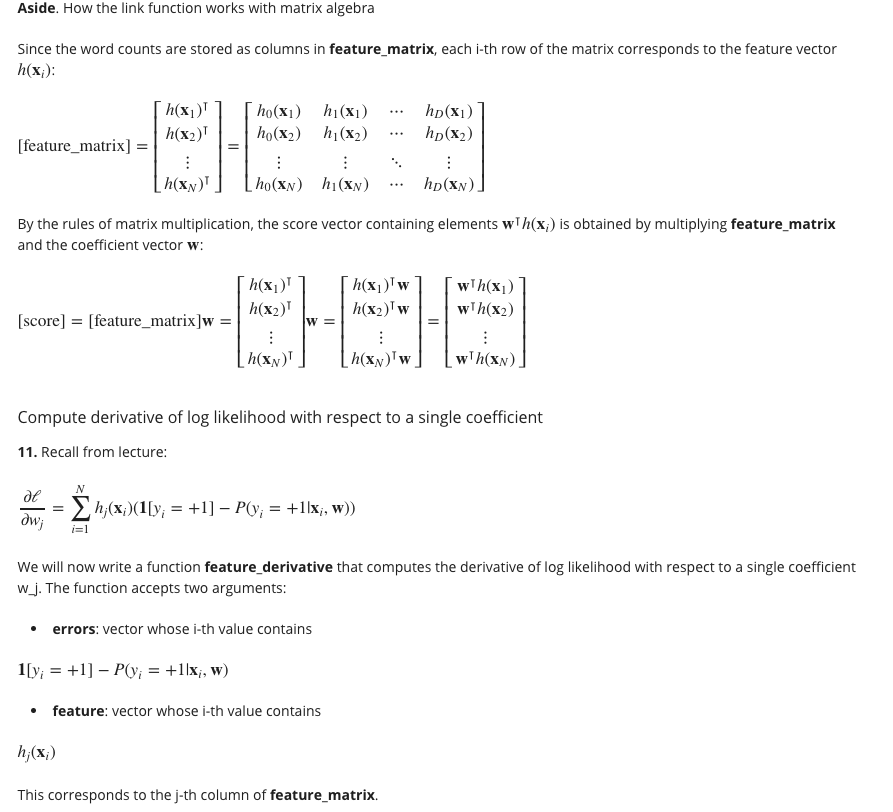

In [19]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
        # Return the derivative
    return derivative

In the main lecture, our focus was on the likelihood. In the advanced optional video, however, we introduced a transformation of this likelihood---called the log-likelihood---that simplifies the derivation of the gradient and is more numerically stable. Due to its numerical stability, we will use the log-likelihood instead of the likelihood to assess the algorithm.

The log-likelihood is computed using the following formula (see the advanced optional video if you are curious about the derivation of this equation):

In [20]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

In [21]:
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])
dummy_sentiment = np.array([-1, 1])

correct_indicators  = np.array( [ -1==+1,                                       1==+1 ] )
correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),                     1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_first_term  = np.array( [ (correct_indicators[0]-1)*correct_scores[0],  (correct_indicators[1]-1)*correct_scores[1] ] )
correct_second_term = np.array( [ np.log(1. + np.exp(-correct_scores[0])),      np.log(1. + np.exp(-correct_scores[1])) ] )

correct_ll          =      sum( [ correct_first_term[0]-correct_second_term[0], correct_first_term[1]-correct_second_term[1] ] ) 

print ('The following outputs must match ')
print ('------------------------------------------------')
print ('correct_log_likelihood           =', correct_ll)
print ('output of compute_log_likelihood =', compute_log_likelihood(dummy_feature_matrix, dummy_sentiment, dummy_coefficients))

The following outputs must match 
------------------------------------------------
correct_log_likelihood           = -5.331411615436032
output of compute_log_likelihood = -5.331411615436032


### Taking gradient steps
Now we are ready to implement our own logistic regression. All we have to do is to write a gradient ascent function that takes gradient steps towards the optimum.

Write a function logistic_regression to fit a logistic regression model using gradient ascent.

The function accepts the following parameters:

feature_matrix: 2D array of features sentiment: 1D array of class labels initial_coefficients: 1D array containing initial values of coefficients step_size: a parameter controlling the size of the gradient steps max_iter: number of iterations to run gradient ascent The function returns the last set of coefficients after performing gradient ascent.

The function carries out the following steps:

Initialize vector coefficients to initial_coefficients. Predict the class probability P(y_i = +1 | x_i,w) using your predict_probability function and save it to variable predictions. Compute indicator value for (y_i = +1) by comparing sentiment against +1. Save it to variable indicator. Compute the errors as difference between indicator and predictions. Save the errors to variable errors. For each j-th coefficient, compute the per-coefficient derivative by calling feature_derivative with the j-th column of feature_matrix. Then increment the j-th coefficient by (step_size*derivative). Once in a while, insert code to print out the log likelihood. Repeat steps 2-6 for max_iter times.

In [22]:
from math import sqrt

def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = np.dot(errors, feature_matrix[:,j])

            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + step_size * derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
                                    or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                                                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

Now, let us run the logistic regression solver with the parameters below:

In [23]:

feature_matrix = feature_matrix 
sentiment = label_array
initial_coefficients = np.zeros(194)
step_size = 1e-7
max_iter = 301


In [24]:
variable_coefficients = logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

**Quiz question: As each iteration of gradient ascent passes, does the log likelihood increase or decrease?**

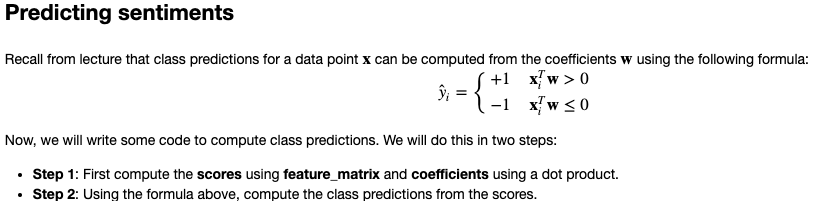

**Quiz question: How many reviews were predicted to have positive sentiment?**

In [25]:
# Compute the scores as a dot product between feature_matrix and coefficients.
scores = np.dot(feature_matrix, variable_coefficients)
predicted_sentiment = np.array([+1 if s > 0 else -1 for s in scores])
sum(predicted_sentiment == +1)

25126

In [26]:
unique, counts = np.unique(predicted_sentiment, return_counts=True)
print( unique, counts)

[-1  1] [27946 25126]


### Measuring accuracy
We will now measure the classification accuracy of the model. Recall from the lecture that the classification accuracy can be computed as follows:

In [27]:
float(sum(predicted_sentiment == sentiment))/len(sentiment)

0.7518653904130238

### Which words contribute most to positive & negative sentiments

Recall that in the earlier assignment, we were able to compute the "most positive words". These are words that correspond most strongly with positive reviews. In order to do this, we will first do the following:

Treat each coefficient as a tuple, i.e. (word, coefficient_value). The intercept has no corresponding word, so throw it out. Sort all the (word, coefficient_value) tuples by coefficient_value in descending order. Save the sorted list of tuples to word_coefficient_tuples.

In [28]:
coefficients = list(variable_coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

In [29]:
word_coefficient_tuples[:10]

[('great', 0.06654608417045771),
 ('love', 0.06589076292212326),
 ('easy', 0.0647945868025784),
 ('little', 0.04543562630842137),
 ('loves', 0.04497640139490604),
 ('well', 0.03013500109210707),
 ('perfect', 0.029739937104968462),
 ('old', 0.020077541034775385),
 ('nice', 0.018408707995268992),
 ('daughter', 0.017703199905701694)]

In [30]:
word_coefficient_tuples_negative  = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=False)

In [31]:
word_coefficient_tuples_negative[:10]

[('would', -0.05386014844520313),
 ('product', -0.0415110333921089),
 ('money', -0.038982037286487116),
 ('work', -0.03306951529475272),
 ('even', -0.030051249236035808),
 ('disappointed', -0.028978976142317068),
 ('get', -0.028711552980192588),
 ('back', -0.027742697230661334),
 ('return', -0.026592778462247283),
 ('monitor', -0.024482100545891717)]